In [1]:
import torch
import numpy as np

In [2]:
from matplotlib import pyplot

In [3]:
import idx2numpy

In [4]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torch import optim
from PIL import Image

In [5]:

class MNIST(Dataset):
    def __init__(self, root, transforms=None):
        
        self.labels = idx2numpy.convert_from_file(root+'/labels')
        self.images = idx2numpy.convert_from_file(root+'/images')
        print(self.labels)
        self.transforms = transforms

    def __len__(self):
        return self.labels.shape[0]

    def __getitem__(self, id):
        image = Image.fromarray( self.images[id] , 'L')
        label = self.labels[id]
        #print(label)
        return self.transforms(image).view(1, 1, 26, 26), label

In [6]:
transform = transforms.Compose([ transforms.Resize(26), transforms.ToTensor()])

dataset = [MNIST('mnist/Train', transform), MNIST('mnist/Test', transform)]
dataloader = [DataLoader(x, batch_size=128, shuffle=True, num_workers=0) for x in dataset]

[5 0 4 ... 5 6 8]
[7 2 1 ... 4 5 6]


In [7]:
# New way of taking tensors. We do not have a separate computational graph. We just remember what everything is connected to and run a simple DFS style function backwards.

In [8]:
# To connect new tensors we have a simple method. When two tensors are active often, we make a connection. The architexture seems to be 

In [36]:
from torch import sparse
import torch
import random
# Using sparse matrices after confirming that the above works.
class Model(torch.nn.Module):
    # Initial connections are randomly formed
    def __init__(self):
        super(Model, self).__init__()
        connections_per_neuron = 15
        layers = 15
        conv_output =  layers* 22* 22
        num_neurons = 64
        # Random Neron Structured
        with torch.no_grad():
            neurons = torch.arange(num_neurons).view(-1)
            neurons = torch.cat(connections_per_neuron*[neurons]).view(-1)
            indices = torch.LongTensor(torch.randint(low=0, high=num_neurons, size=(num_neurons*connections_per_neuron,))).view(-1)
            i = torch.stack((neurons, indices))
            i.requires_grad_(False)
            values = (torch.rand(num_neurons*connections_per_neuron).view(-1)*2-1)
            self.neuron_weights_sparse = torch.nn.Parameter(torch.sparse.FloatTensor(i, values, torch.Size([num_neurons,num_neurons])))
            self.neuron_activations = []
            self.neuron_biases = torch.nn.Parameter(torch.zeros(num_neurons).view(-1, 1))
        
        # Outputs
        with torch.no_grad():
            outputs = torch.arange(10).view(-1)
            outputs = torch.cat(connections_per_neuron*[outputs]).view(-1)
            indices = torch.LongTensor(torch.randint(low=0, high=num_neurons, size=(10*connections_per_neuron,))).view(-1)
            i = torch.stack((outputs, indices))
            i.requires_grad_(False)
            values = (torch.rand(10*connections_per_neuron).view(-1))
            self.outputs_weights_sparse = torch.nn.Parameter(torch.sparse.FloatTensor(i, values, torch.Size([10, num_neurons])))
            self.outputs_biases = torch.nn.Parameter(torch.zeros(10).view(-1,1))
        
        # Inputs
        # First Conv because this aint it
        self.first_conv = torch.nn.Conv2d(1, layers, 5)
        with torch.no_grad():
            neurons = torch.arange(num_neurons).view(-1)
            neurons = torch.cat(connections_per_neuron*[neurons]).view(-1)
            indices = torch.LongTensor(torch.randint(low=0, high=conv_output, size=(num_neurons*connections_per_neuron,))).view(-1)
            i = torch.stack((neurons, indices))
            i.requires_grad_(False)
            values = (torch.rand(num_neurons*connections_per_neuron).view(-1)*2-1)
            self.inputs_weights_sparse = torch.nn.Parameter(torch.sparse.FloatTensor(i, values, torch.Size([num_neurons,conv_output])))
            self.inputs_biases = torch.nn.Parameter(torch.zeros(num_neurons).view(-1, 1))
        self.CSE = torch.nn.CrossEntropyLoss()
        self.activation = lambda x: torch.nn.LeakyReLU(0.2)(x)
        del neurons
        del indices
        del i
        del values
    def through_input(self, input_img):
        # Send input image into neurons
        first_conv = self.activation(self.first_conv(input_img).view(-1,1))
        
        self.neuron_activations.append(self.activation(torch.sparse.addmm( mat=self.inputs_biases, mat2=first_conv, mat1=self.inputs_weights_sparse)))

    def update(self):
        
        # Update the neurons
        _=len(self.neuron_activations)-1
        #print(self.neuron_activations[_])
        self.neuron_activations.append(self.activation(torch.sparse.addmm(mat=self.neuron_biases,
                                                                     mat2=self.neuron_activations[_], 
                                                                     mat1=self.neuron_weights_sparse)))
        #print(self.neuron_activations[_+1])
        
    def loss(self,correct):

        # Update the outputs
        _=len(self.neuron_activations)-1
        outputs_activations = self.activation(torch.sparse.mm(mat2=self.neuron_activations[_], mat1=self.outputs_weights_sparse))
        #if random.random() < .2:
        #    print(outputs_activations)
        #print(outputs_activations.argmax(), correct.argmax())
        
        yes = outputs_activations.argmax()==correct
        #print(outputs_activations.argmax(), correct)
        return self.CSE(outputs_activations[None], correct[None]), yes.data
    
    def reset(self):
        del self.neuron_activations
        self.neuron_activations = []
        
        # We also want to reset all the weights so that only the initial nonzero terms are still non zero
    def coalesce(self):
        self.neuron_weights_sparse.data  = self.neuron_weights_sparse.coalesce()
        self.inputs_weights_sparse.data  = self.inputs_weights_sparse.coalesce()
        self.outputs_weights_sparse.data = self.outputs_weights_sparse.coalesce()
        
        
model = Model()
##print('loaded')
model.to(torch.device("cuda:0"))
optimizer = optim.SGD(model.parameters(), lr=0.005, momentum=0.1)
#optimizer = torch.optim.S(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08)
losses = []
acc = []
#ca = 0
import time
#l=torch.Tensor([0]).to(torch.device("cuda:0"))
for i in range(20000):
    if i % 10 == 0:
        print(i)
        acc.append(ca/10)
        print(ca/10)
        ca = 0

    #a=time.time()
    with torch.no_grad():
        model.reset()
        model.coalesce()
    if i % 25 == 0:
        optimizer.zero_grad()
        
    
    # For some reason we cannot use any default optimizer on this so we must use our own standard version.
    img, label = dataset[0][i]
    img = img.to(torch.device("cuda:0"))
    
    model.through_input(img)

    for _ in range(8):
        model.update()
    correct_tensor = torch.zeros(10)
    correct_tensor[label] = 1
    correct_tensor = correct_tensor.to(torch.device("cuda:0"))
    output, yes = model.loss(torch.LongTensor([label]).to(torch.device("cuda:0")))

    if yes:
        ca+=1
    #print(torch.cuda.memory_allocated(0))
    output.backward(retain_graph = False)
    if i%25==0:
        print(output)
    #print(torch.cuda.memory_allocated(0))
    optimizer.coalesce()
    
    #print(torch.cuda.memory_allocated(0))
    if i%25==0:
        optimizer.step()
    losses.append(output.detach().cpu().numpy())
    #print(time.time()-a)
    #print(model.neuron_weights_sparse.coalesce().indices().shape)
    del img
    #del l
    #del element
    
    #optimizer.coalesce()
    

 

0
0.0
tensor(39.6448, device='cuda:0', grad_fn=<NllLoss2DBackward>)
10
0.1
20
0.1
tensor(56.4320, device='cuda:0', grad_fn=<NllLoss2DBackward>)
30
0.1
40
0.1
50
0.1
tensor(120.6327, device='cuda:0', grad_fn=<NllLoss2DBackward>)
60
0.0
70
0.0
tensor(61.5816, device='cuda:0', grad_fn=<NllLoss2DBackward>)
80
0.2
90
0.2
100
0.2
tensor(20.8859, device='cuda:0', grad_fn=<NllLoss2DBackward>)
110
0.0
120
0.0
tensor(21.6448, device='cuda:0', grad_fn=<NllLoss2DBackward>)
130
0.1
140
0.2
150
0.0
tensor(2.1465, device='cuda:0', grad_fn=<NllLoss2DBackward>)
160
0.0
170
0.3
tensor(20.6828, device='cuda:0', grad_fn=<NllLoss2DBackward>)
180
0.1
190
0.1
200
0.1
tensor(6.6981, device='cuda:0', grad_fn=<NllLoss2DBackward>)
210
0.0
220
0.2
tensor(5.6711, device='cuda:0', grad_fn=<NllLoss2DBackward>)
230
0.1
240
0.1
250
0.0
tensor(5.2777, device='cuda:0', grad_fn=<NllLoss2DBackward>)
260
0.2
270
0.0
tensor(0.5283, device='cuda:0', grad_fn=<NllLoss2DBackward>)
280
0.4
290
0.2
300
0.3
tensor(3.3942, device='

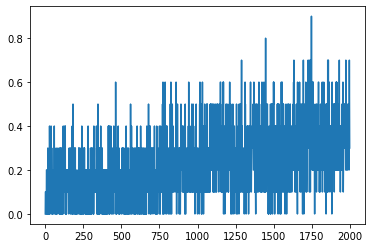

In [37]:
pyplot.plot(acc)

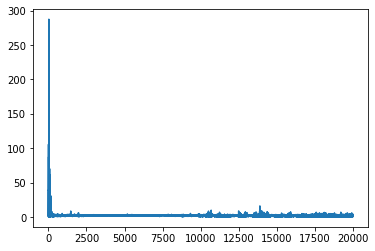

In [41]:
pyplot.plot(losses)

In [28]:
import torch
import gc
for obj in gc.get_objects():
    try:
        if torch.is_tensor(obj) or (hasattr(obj, 'data') and torch.is_tensor(obj.data)):
            print(type(obj), obj.size())
    except:
        pass

<class 'torch.nn.parameter.Parameter'> torch.Size([17576, 17576])
<class 'torch.Tensor'> torch.Size([2, 878800])
<class 'torch.nn.parameter.Parameter'> torch.Size([17576, 1])
<class 'torch.nn.parameter.Parameter'> torch.Size([10, 17576])
<class 'torch.nn.parameter.Parameter'> torch.Size([17576, 676])
<class 'torch.nn.parameter.Parameter'> torch.Size([17576, 1])
<class 'torch.Tensor'> torch.Size([])


In [171]:
l = []
for i in range(len(losses)//10):
    l.append(sum(losses[i:i+10]))

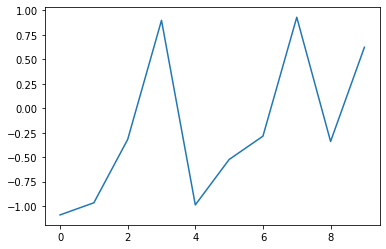

In [47]:
pyplot.plot(model.outputs_biases.detach().cpu().numpy())

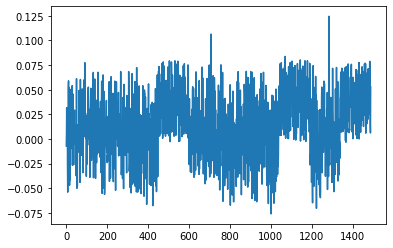

In [50]:
pyplot.plot(model.outputs_weights_sparse.coalesce().values().detach().cpu().numpy())

In [274]:
acc

[0.5,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]

In [72]:
# We will be very basic. For any two things that are activated together twice in a row, we will connect them.
# Our update will be very simple. You take each self.neurons connections and just set the next rounds values to that at each step.
# Then to backprop, you remember what each self.neuron has as its self.outputs and that will store your computational graph. Then backrpop. For now, I'm just usin ga massive
# matrix to store connections.
# We will store the self.neurons as a cube with shape 2 million total which will be a 26 by 26 by 26 for hte first cnn and then a 12 by1 12 for the dense layer then a final 10
# To model the activations its probably easier to store them as a list. This will make it smaller. 
# For updating you look at the nodes in front of you. 
# Final thing to deal with negative numbers. A self.neuron can be either inhi
class Model(torch.nn.Module):
    # Initial connections are randomly formed
    def __init__(self):
        super(Model, self).__init__()
        self.neuron_activations = [[[1]*26]*26]*26 # Where the final layer is supposed to be the dense one. This layer represents the activations
        self.next_neuron_activations = np.zeros_like(self.neuron_activations)


        self.outputs = [1]*10
        self.outputs_inputs = np.zeros((10, 40, 3))
        self.outputs_weights = [[1]*40]*10
        self.neuron_inputs = np.zeros((26, 26, 26, 50, 3)) # 50 connections max for a self.neuron. 2 is because first three say which one. Next says weight. Final says gradients.
        self.neuron_weights = [[[[1]*50]*26]*26]*26 # This is a list of torch tensors to make calculations easier
        # We will delete connections over time.
        #self.neuron_inputs = np.zeros_like(self.outputs) # Same thing for inputs
        self.neuron_biases = torch.nn.Parameter(torch.zeros(26, 26, 26)+25) # Biases
        # We estimate the inputs as roughly going forwards, but not necessarily
        for layer in range(26):
            self.neuron_inputs[layer,:,:,:,0] = (layer*abs(np.random.randn(1, 26, 26, 50))).clip(0, 25)
            self.neuron_inputs[layer,:,:,:,1] = (np.random.randn(1, 26, 26, 50)*3+np.arange(26).reshape(1, 26, 1, 1)).clip(0, 25)
            self.neuron_inputs[layer,:,:,:,2] = (np.random.randn(1, 26, 26, 50)*3+np.arange(26).reshape(1, 1, 26, 1)).clip(0, 26)
        for i in range(26):
            for j in range(26):
                for k in range(26):
                    for l in range(50):
                        self.neuron_weights[i][j][k][l] = torch.nn.Parameter(torch.randn(1))
                        self.neuron_activations[i][j][k] = torch.zeros(1)
                        self.next_neuron_activations[i][j][k] = torch.zeros(1)
        # For the self.outputs we select things from the final layer
        self.outputs_inputs[:,:,0] = (26-np.random.randn(10, 40)*26).clip(0, 25)
        self.outputs_inputs[:,:,1] = (26-np.random.randn(10, 40)*26).clip(0, 25)
        self.outputs_inputs[:,:,2] = (26-np.random.randn(10, 40)*26).clip(0, 25)
        for i in range(10):
            for j in range(40):
                self.outputs_weights[i][j] = torch.randn(1)
                self.outputs[i] = torch.zeros(1)


    def update(self):
        # Loop through all self.neurons and then calculate the new value 
        for i in range(26):
            print(i)
            for j in range(26):
                for k in range(26):
                    current_sum=torch.zeros(1)
                    for l in range(50):
                        current_sum += self.neuron_activations[int(self.neuron_inputs[i, j, k, l, 0])][int(self.neuron_inputs[i, j, k, l, 1])][int(self.neuron_inputs[i, j, k, l, 2])]*self.neuron_weights[i][j][k][l]
                    current_sum+=self.neuron_biases[i, j, k]
                    self.next_neuron_activations[i][j][k] = torch.nn.ReLU()(current_sum)
        for i in range(10):
            current_sum=torch.zeros(1)
            for j in range(40):
                current_sum += self.neuron_activations[int(self.outputs_inputs[i, j, 0])][int(self.outputs_inputs[i, j, 1])][int(self.outputs_inputs[i, j, 2])]*self.outputs_weights[i][j]
        
            self.outputs[i] = torch.nn.ReLU()(current_sum)
        self.neuron_activations = self.next_neuron_activations
        for i in range(26):
            for j in range(26):
                for k in range(26):
                    self.next_neuron_activations[i][j][k] = torch.zeros(1)
                
    def loss(self,correct):
        s = torch.zeros(1)
        for i in range(10):
            if i != correct:
                s+=self.outputs[i]
            else:
                s+=1-self.outputs[i]
        return s
model = Model()
print('Initialized')
optimizer = optim.SGD(model.parameters(), lr=0.6, momentum=0.9)
for i in range(5):
    img, label = dataset[1][i]
    
    for j in range(26):
        for k in range(26):
            model.neuron_activations[0][j][k] = img[0, i, j]
    for _ in range(15):
        optimizer.zero_grad()
        model.update()
        print(l)
        l = model.loss(label)
        optimizer.step()
        del l
    
# Connection weights
# If a self.neuron connection is not used,  
# This will create connections 
    
    

Initialized
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
tensor([1.])
0


OverflowError: Python int too large to convert to C long

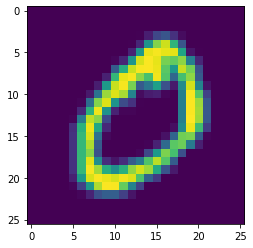

In [267]:
pyplot.imshow(dataset[0][1][0].cpu().numpy().reshape(26,26))